# Degradation and attacks on networks

In [122]:
# numpy
import numpy
from numpy.random import default_rng

# simulation
from epyc import Experiment
from epydemic import ERNetwork, BANetwork, PLCNetwork, Percolate, StochasticDynamics, Process, ProcessSequence

# networks
import networkx
from collections import Counter

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

## Degradation

In [123]:
class PercolateLCC(Process):
    '''A process that bond percolates a network and counts the size
    of the largest component.
    '''

    # Experimental parameters
    T = Percolate.T
    STEP = "samplestep"

    # Results
    LCC = "lcc"

    def __init__(self):
        super().__init__()

    def percolate(self, T, step):
        '''Percolate the network.
        
        :param T: the occupation probability
        :param step: the sample step
        '''
        g = self.network()
        rng = default_rng()
    
        # create a list of edges
        es = list(g.edges())
        
        # determine those edges that are unoccupied
        unoccupied = []
        self._largest = []
        for e in es:
            if rng.random() > T:
                # edge should be removed
                unoccupied.append(e)
                
        # remove the edges, sampling the network as we go
        n = 0
        for e in unoccupied:
            g.remove_edge(*e)
            
            # sample if needed
            n += 1
            if n % step == 0:
                # sample the size of the largest component
                largest = max(map(len, networkx.connected_components(g)))
                self._largest.append(largest)
        
        # add the size of the largest component at the end
        if n % step != 0:
            largest = max(map(len, networkx.connected_components(g)))
            self._largest.append(largest)

    def build(self, params):
        '''Percolate the network.

        :param params: the experimental parameters'''
        super().build(params)

        # percolate the network
        T = params[self.T]
        step = params[self.STEP]
        self.percolate(T, step)
        
    def results(self):
        '''Generate the component size series.
        
        :returns: a dict of results'''
        rc = super().results()
        rc[self.LCC] = self._largest.copy()
        return rc

### Degrading ER networks

In [124]:
# the size of the networks
N = int(1e4)

# ER
kmean = 5

# the occupation probability
T = 0.10                       # retain 10% of the edges

In [125]:
params_er = dict()
params_er[ERNetwork.N] = N
params_er[ERNetwork.KMEAN] = kmean
params_er[PercolateLCC.T] = T
params_er[PercolateLCC.STEP] = 100

In [126]:
m = PercolateLCC()
e_er = StochasticDynamics(m, ERNetwork())
rc_er = e_er.set(params_er).run()

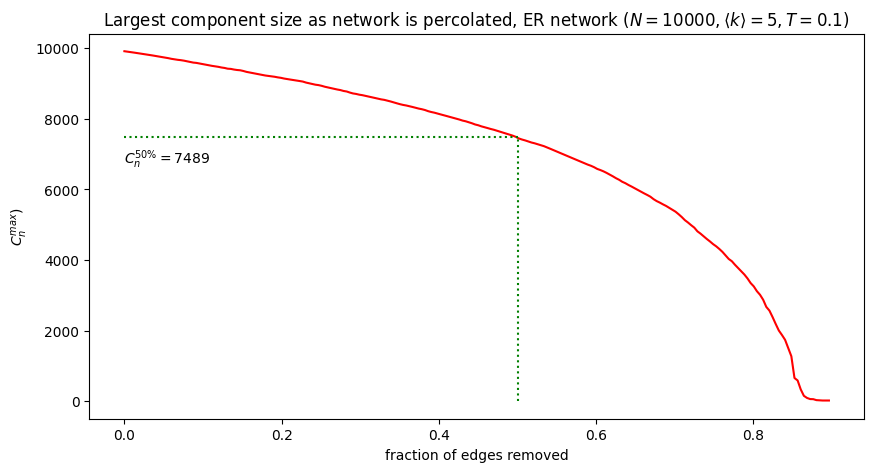

In [127]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# work out the fraction of edges removed at each step, as a range
cs = rc_er[Experiment.RESULTS][PercolateLCC.LCC]
fraction_removed_per_step = (1 - params[Percolate.T]) / len(cs)
fs = [fraction_removed_per_step * i for i in range(len(cs))]

# plot the largest component size
ax.plot(fs, cs, 'r-')
                        
# plot LCC size when 50% of edges have been removed
r50 = int(len(cs) / (1 - params[Percolate.T]) * 0.5)
cn50 = cs[r50]
ax.plot([0.5, 0.5], [0.0, cn50],
        color='green', linestyle='dotted')
ax.plot([0.5, 0.0], [cn50, cn50],
        color='green', linestyle='dotted')
ax.annotate('$C_n^{50\%} = ' + f'{cn50}$',[0.0, cn50],
            [0.0, cn50 * 0.9])

# set title and axis limits
ax.set_title(f'Largest component size as network is percolated, ER network ($N = {N}, \\langle k \\rangle = {kmean}, T = {T}$)')
ax.set_xlabel('fraction of edges removed')
ax.set_ylabel('$C_n^{max}$)')
plt.savefig("lcc-er.png")
plt.show()

### Degrading PLC networks

In [128]:
# PLC
exponent = 2.5
cutoff = 200

In [129]:
params_plc = dict()
params_plc[PLCNetwork.N] = N
params_plc[PLCNetwork.EXPONENT] = exponent
params_plc[PLCNetwork.CUTOFF] = cutoff
params_plc[PercolateLCC.T] = T
params_plc[PercolateLCC.STEP] = 100

In [137]:
e_plc = StochasticDynamics(m, PLCNetwork())
rc_plc = e_plc.set(params_plc).run()

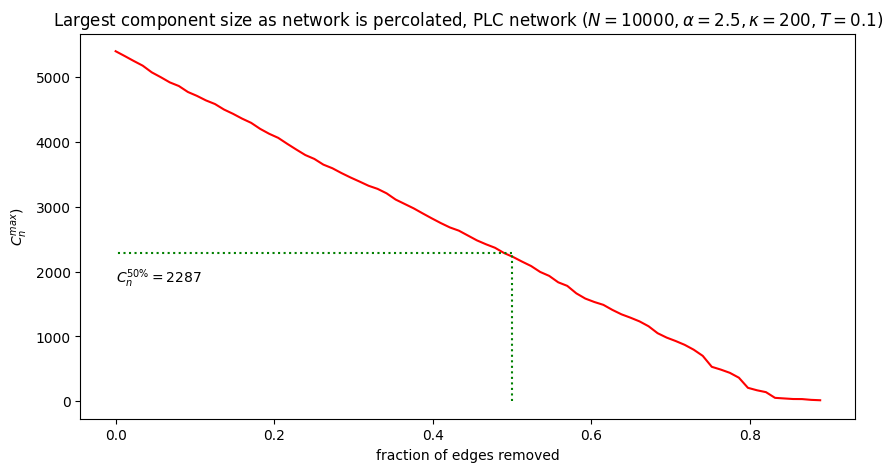

In [138]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# work out the fraction of edges removed at each step, as a range
cs = rc_plc[Experiment.RESULTS][PercolateLCC.LCC]
fraction_removed_per_step = (1 - params[Percolate.T]) / len(cs)
fs = [fraction_removed_per_step * i for i in range(len(cs))]

# plot the largest component size
ax.plot(fs, cs, 'r-')
                        
# plot LCC size when 50% of edges have been removed
r50 = int(len(cs) / (1 - params[Percolate.T]) * 0.5)
cn50 = cs[r50]
ax.plot([0.5, 0.5], [0.0, cn50],
        color='green', linestyle='dotted')
ax.plot([0.5, 0.0], [cn50, cn50],
        color='green', linestyle='dotted')
ax.annotate('$C_n^{50\%} = ' + f'{cn50}$',[0.0, cn50],
            [0.0, cn50 * 0.8])

# set title and axis limits
ax.set_title(f'Largest component size as network is percolated, PLC network ($N = {N}, \\alpha = {exponent}, \\kappa = {cutoff}, T = {T}$)')
ax.set_xlabel('fraction of edges removed')
ax.set_ylabel('$C_n^{max}$)')
plt.savefig("lcc-plc.png")
plt.show()

### Degrading BA networks

In [132]:
# BA
M = 3

In [133]:
params_ba = dict()
params_ba[BANetwork.N] = N
params_ba[BANetwork.M] = M
params_ba[PercolateLCC.T] = T
params_ba[PercolateLCC.STEP] = 100

In [139]:
e_ba = StochasticDynamics(m, BANetwork())
rc_ba = e_ba.set(params_ba).run()

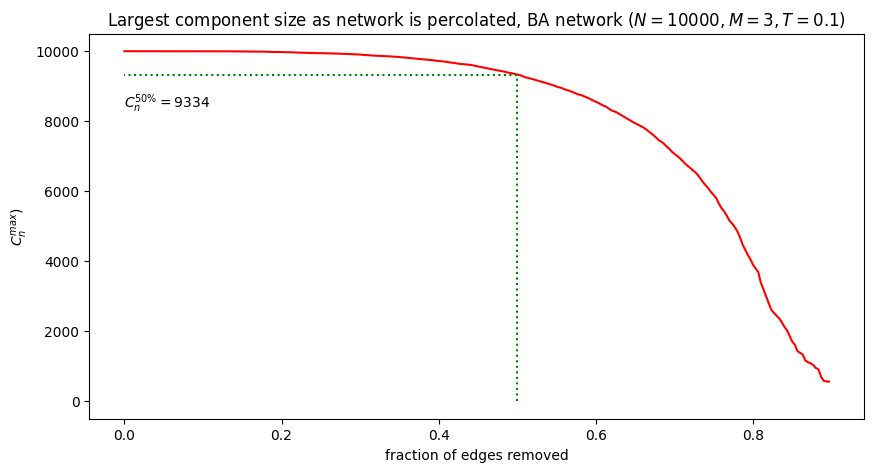

In [140]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# work out the fraction of edges removed at each step, as a range
cs = rc_ba[Experiment.RESULTS][PercolateLCC.LCC]
fraction_removed_per_step = (1 - params[Percolate.T]) / len(cs)
fs = [fraction_removed_per_step * i for i in range(len(cs))]

# plot the largest component size
ax.plot(fs, cs, 'r-')
                        
# plot LCC size when 50% of edges have been removed
r50 = int(len(cs) / (1 - params[Percolate.T]) * 0.5)
cn50 = cs[r50]
ax.plot([0.5, 0.5], [0.0, cn50],
        color='green', linestyle='dotted')
ax.plot([0.5, 0.0], [cn50, cn50],
        color='green', linestyle='dotted')
ax.annotate('$C_n^{50\%} = ' + f'{cn50}$',[0.0, cn50],
            [0.0, cn50 * 0.9])

# set title and axis limits
ax.set_title(f'Largest component size as network is percolated, BA network ($N = {N}, M = {M}, T = {T}$)')
ax.set_xlabel('fraction of edges removed')
ax.set_ylabel('$C_n^{max}$)')
plt.savefig("lcc-ba.png")
plt.show()

## Attacks on BA networks

In [241]:
class AttackLCC(Process):
    '''A process that bond percolates a network in an attack mode,
    by default removing high-degree nodes preferentially, and counts the size
    of the largest component, the average shortest path length, andthe diameter
    of the network.
    '''

    # Experimental parameters
    F = "attack"

    # Results
    LCC = "lcc"
    DIAMETER = "diameter"
    SPMEAN = "mean-shortest-path"

    def __init__(self):
        super().__init__()

    def attack(self, F):
        '''Attack the network.
        
        :param F: the number of highest-degree nodes to remove
        '''
        g = self.network()
        rng = default_rng()
        
        # order the nodes by degree
        ds = list(g.degree())
        g_attack = sorted(ds, key=lambda nd: nd[1], reverse=True)

        # remove the top F high-degree nodes, sampling as we go
        self._largest = [max(map(len, networkx.connected_components(g)))]
        self._diameter = [networkx.diameter(g)]
        self._spmean = [networkx.average_shortest_path_length(g)]
        for i in range(F):
            g.remove_node(g_attack[i][0])
            self._largest.append(max(map(len, networkx.connected_components(g))))
            self._diameter.append(networkx.diameter(g))
            self._spmean.append(networkx.average_shortest_path_length(g))
            
    def build(self, params):
        '''Attack the network.

        :param params: the experimental parameters'''
        super().build(params)

        # attack the network
        F = params[self.F]
        self.attack(F)
        
    def results(self):
        '''Generate the component size series.
        
        :returns: a dict of results'''
        rc = super().results()
        rc[self.LCC] = self._largest
        rc[self.DIAMETER] = self._diameter
        rc[self.SPMEAN] = self._spmean
        return rc

In [243]:
F = 500

In [244]:
params_attack = dict()
params_attack[BANetwork.N] = N
params_attack[BANetwork.M] = M
params_attack[AttackLCC.F] = F

In [245]:
m = AttackLCC()
e_attack = StochasticDynamics(m, BANetwork())
rc_attack = e_attack.set(params_attack).run()

Caught exception in experiment: Found infinite path length because the graph is not connected


In [236]:
rc_attack

{'parameters': {'N': 10000, 'MperNode': 3, 'attack': 2000, 'topology': 'BA'},
 'metadata': {'epyc.experiment.classname': 'epydemic.stochasticdynamics.StochasticDynamics',
  'epyc.experiment.start_time': datetime.datetime(2023, 8, 3, 18, 43, 28, 893434),
  'epyc.experiment.elapsed_time': 0,
  'epyc.experiment.end_time': datetime.datetime(2023, 8, 3, 18, 44, 36, 702407),
  'epyc.experiment.status': False,
  'epyc.experiment.exception': TypeError("'int' object is not iterable"),
  'epyc.experiment.traceback': 'Traceback (most recent call last):\n  File "/home/sd80/programming/cs5928/venv3/lib/python3.11/site-packages/epyc/experiment.py", line 240, in run\n    self.setUp(params)\n  File "/home/sd80/programming/cs5928/venv3/lib/python3.11/site-packages/epydemic/networkdynamics.py", line 142, in setUp\n    self._process.build(params)\n  File "/tmp/ipykernel_398535/2600263168.py", line 45, in build\n    self.attack(F)\n  File "/tmp/ipykernel_398535/2600263168.py", line 35, in attack\n    self

KeyError: 'lcc'

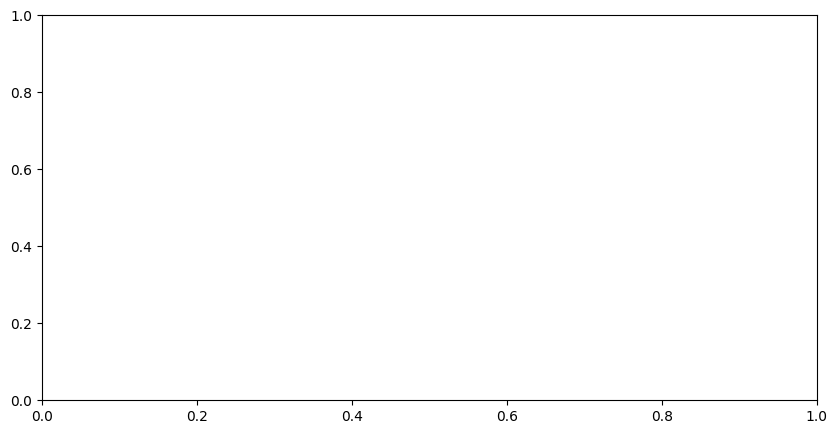

In [235]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# plot the largest component size
cs = rc_attack[Experiment.RESULTS][AttackLCC.LCC]
ax.plot(range(F), cs, 'r-')
                        
# set title and axis limits
ax.set_title(f'Largest component size as network has nodes removed, BA network ($N = {N}, M = {M}, F = {F}$)')
ax.set_xlabel('number of nodes removed')
ax.set_ylabel('$C_n^{max}$)')
ax.set_ylim([0, N])
plt.savefig("lcc-attack.png")
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# plot the largest component size
cs = rc_attack[Experiment.RESULTS][AttackLCC.DIAMETER]
ax.plot(range(F), cs, 'r-')
                        
# set title and axis limits
ax.set_title(f'Diameter as network has nodes removed, BA network ($N = {N}, M = {M}, F = {F}$)')
ax.set_xlabel('number of nodes removed')
ax.set_ylabel('$C_n^{max}$)')
plt.savefig("lcc-diameter.png")
plt.show()